# Dataset Preparation

Dataset: https://www.kaggle.com/xainano/handwrittenmathsymbols

A function is defined to read an image in single channel (greyscale), invert it to have white object on a black background (for better performance during contour extraction), to extract contours and find their bounding rectangles. The bounding rectangle with the maximum area is selected, resized to 28 by 28, and reshaped to have 784 pixel values.

The function is called on images for numbers 0-9, along with those of addition, subtraction, multiplication and division operators as well as simple parentheses. An additional value is appended to each result returned to label the symbol, with numbers 0-9 marked by their respective digits, and numbers 10 to 15 denoting +, -, /, *, (, and ) respectively. The values of all the images are combined and saved as a dataframe and exported to a CSV file to train the model.

In [1]:
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
def prepare_from(folder):
    data=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            ret,thresh=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
            thresh=~thresh
            contours=(cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE))[0]
            sorted_contours=sorted(contours,key=lambda ctr:cv2.boundingRect(ctr)[0])
            h=w=int(28)
            m=0
            for c in sorted_contours:
                x,y,w,h=cv2.boundingRect(c)
                m=max(w*h,m)
                if m==(w*h):
                    x_max=x
                    y_max=y
                    w_max=w
                    h_max=h
            img_crop=thresh[y_max:y_max+h_max,x_max:x_max+w_max]
            img_resize=cv2.resize(img_crop,(28,28))
            img_resize=np.reshape(img_resize,(784,1))
            data.append(img_resize)
    split=int(len(data)*0.7)
    train_data=data[:split]
    test_data=data[split:]
    return train_data,test_data

In [3]:
train_data=[]
test_data=[]

In [4]:
train_data,test_data=prepare_from('data/extracted_images/0')

for i in range(0,len(train_data)):
    train_data[i]=np.append(train_data[i],['0'])
for i in range(0,len(test_data)):
    test_data[i]=np.append(test_data[i],['0'])
    

In [5]:
for x in range(1,10):
    train_data1,test_data1=prepare_from('data/extracted_images/{}'.format(str(x)))

    for i in range(0,len(train_data1)):
        train_data1[i]=np.append(train_data1[i],['{}'.format(str(x))])
    for i in range(0,len(test_data1)):
        test_data1[i]=np.append(test_data1[i],['{}'.format(str(x))])

    train_data=np.concatenate((train_data,train_data1))
    test_data=np.concatenate((test_data,test_data1))

In [6]:
symbols={'+':10,'-':11,'forward_slash':12,'times':13,'(':14,')':15}
for x in symbols:
    train_data1,test_data1=prepare_from('data/extracted_images/{}'.format(x))

    for i in range(0,len(train_data1)):
        train_data1[i]=np.append(train_data1[i],['{}'.format(str(symbols[x]))])
    for i in range(0,len(test_data1)):
        test_data1[i]=np.append(test_data1[i],['{}'.format(str(symbols[x]))])

    train_data=np.concatenate((train_data,train_data1))
    test_data=np.concatenate((test_data,test_data1))

In [7]:
df_train=pd.DataFrame(train_data,index=None)
df_test=pd.DataFrame(test_data,index=None)
df_train.to_csv('train.csv',index=False)
df_test.to_csv('test.csv',index=False)

# Model Creation and Training

A Convolutional Neural Network (CNN) model is implemented using the Keras library (based on TensorFlow 2) and trained using the CSV file. The trained model is saved in JSON format along with its weights for future use.

In [8]:
from tensorflow.keras import layers,models,utils,backend
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
backend.set_image_data_format('channels_last')

In [9]:
model=models.Sequential()
model.add(layers.Conv2D(30,(5,5),input_shape=(28,28,1),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(15,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dense(16,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
df_train=pd.read_csv('train.csv',index_col=False)
df_train

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,164,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,127,255,238,178,178,238,141,...,61,0,0,0,0,0,0,0,0,0
2,0,0,255,178,178,178,178,178,178,178,...,77,77,77,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,22,...,44,0,0,0,0,0,0,0,0,0
4,0,0,0,0,22,178,178,178,178,140,...,178,223,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129812,255,255,217,166,115,72,50,28,6,0,...,0,0,0,0,0,0,0,0,0,15
129813,255,255,238,216,194,170,142,113,84,61,...,0,0,0,0,0,0,0,0,0,15
129814,255,255,231,207,182,151,118,86,77,77,...,0,0,0,0,0,0,0,0,0,15
129815,255,255,233,188,144,99,68,48,29,10,...,0,0,0,0,0,0,0,0,0,15


In [11]:
df_test=pd.read_csv('test.csv',index_col=False)
df_test

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,23,23,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,177,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,63,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55643,178,178,187,207,226,245,223,159,96,32,...,0,0,0,0,0,0,0,0,0,15
55644,178,163,120,77,77,77,55,22,0,0,...,244,182,73,0,0,0,0,0,0,15
55645,178,178,178,178,178,178,165,140,115,90,...,0,0,0,0,0,0,0,0,0,15
55646,0,0,0,0,0,0,22,67,111,155,...,0,0,0,0,0,0,0,0,0,15


In [12]:
train_labels=df_train[['784']]
train_cat=utils.to_categorical(train_labels,num_classes=16)

In [13]:
test_labels=df_test[['784']]
test_cat=utils.to_categorical(test_labels,num_classes=16)

In [14]:
df_train.drop(columns='784',inplace=True)
df_test.drop(columns='784',inplace=True)

In [15]:
train_x=[]
test_x=[]
for i in range(df_train.shape[0]):
    train_x.append(np.array(df_train[i:i+1]).reshape(28,28,1))
for i in range(df_test.shape[0]):
    test_x.append(np.array(df_test[i:i+1]).reshape(28,28,1))

In [16]:
early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, mode='max', baseline=None,
                               restore_best_weights=True)

callbacks = [PlotLossesCallback(), early_stopping]

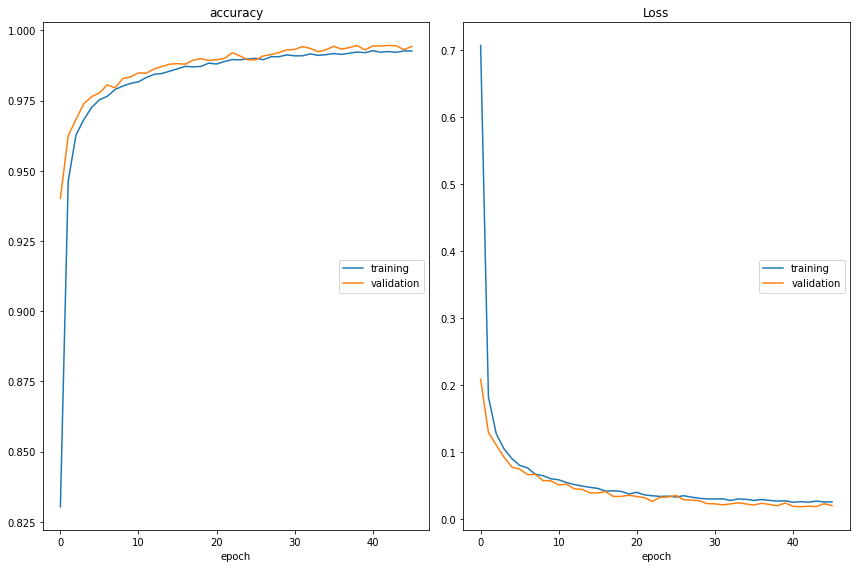

accuracy
	training         	 (min:    0.830, max:    0.993, cur:    0.993)
	validation       	 (min:    0.940, max:    0.995, cur:    0.994)
Loss
	training         	 (min:    0.025, max:    0.707, cur:    0.025)
	validation       	 (min:    0.018, max:    0.208, cur:    0.020)
650/650 - 4s - loss: 0.0251 - accuracy: 0.9927 - val_loss: 0.0196 - val_accuracy: 0.9943 - 4s/epoch - 6ms/step


In [17]:
model.fit(np.array(train_x), train_cat, validation_data=((np.array(test_x)),test_cat), epochs=100, batch_size=200,shuffle=True,verbose=2,callbacks=callbacks)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 15)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 15)          0         
                                                                 
 flatten (Flatten)           (None, 375)               0

In [19]:
model_json = model.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_new.h5")